# Online non-linear regression with corrupted observations

In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "Robust EKF": "crimson",
    "IMQF": "dodgerblue",
    "EKF": "lightseagreen"
}

## Data-generating process

In [3]:
def f(x):
    return x / 5 - 10 * jnp.cos(jnp.pi * x) + x ** 3


def sample_observations_grid(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    key_cchoice, key_cval = jax.random.split(key_corrupted)
    is_corrupted = jax.random.bernoulli(key_cchoice, p=0.05, shape=(n_obs,))
    ycorr = jax.random.uniform(key_cval, (n_obs,), minval=-50, maxval=50)
    
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jax.random.uniform(key_x, (n_obs,), minval=-3, maxval=3)
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + ycorr * is_corrupted
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y



def sample_observations_one_sided(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    is_corrupted = jax.random.bernoulli(key_corrupted, p=0.05, shape=(n_obs,))
        
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + is_corrupted * 50.0
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y

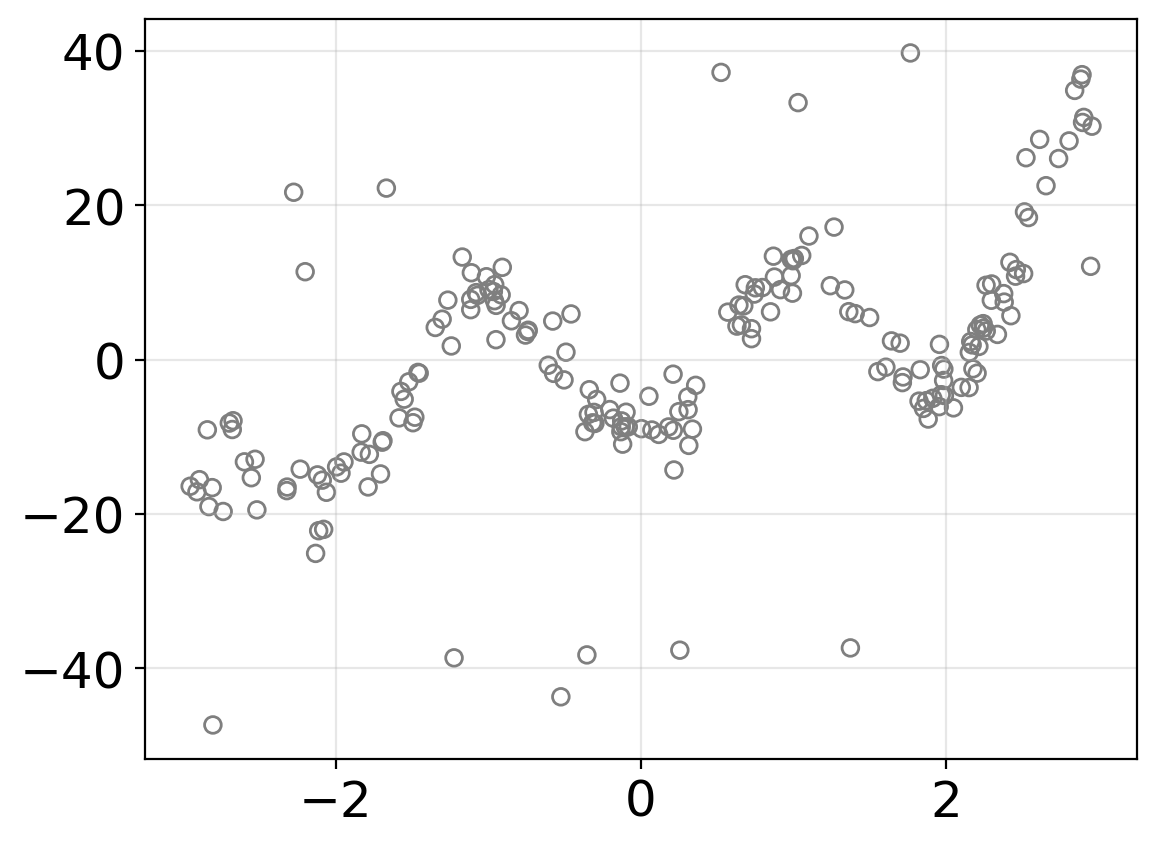

In [4]:
key = jax.random.PRNGKey(31)
key_train, key_sample_obs, key_eval = jax.random.split(key, 3)

n_obs = 200
xmin, xmax = -3, 3
sigma_y = 3.0
x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
xtest = jnp.linspace(x.min(), x.max(), n_obs)
ytest = f(xtest)
plt.scatter(x, y, edgecolors="tab:gray", color="none")
plt.grid(alpha=0.3)

## Filtering

In [5]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat - y

In [6]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = jnp.sin(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

def latent_fn(x): return x

model = MLP()

### Setup
Parameters shared for all methods

In [7]:
dynamics_covariance = 1e-4
observation_covariance = 1.0

cov_init = 1.0
params_init = model.init(key_train, x[:, None])

### Extended Kalman Filter

In [8]:
agent_ekf = gf.ExtendedKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=dynamics_covariance,
    observation_covariance=observation_covariance * jnp.eye(1)
    
)

bel_init = agent_ekf.init_bel(params_init, cov=1.0)
bel_ekf, hist_bel_ekf = agent_ekf.scan(bel_init, y, x[:, None])
yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()

### Robust Extended Kalman Filter

In [9]:
def filter_rkf(noise_scaling):
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        latent_fn, model.apply, dynamics_covariance=dynamics_covariance,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=1
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, hist_pperror = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    return -jnp.power(hist_pperror, 2).mean(), out

In [10]:
bo = BayesianOptimization(
    lambda noise_scaling: filter_rkf(noise_scaling)[0],
    pbounds={
        "noise_scaling": (1e-6, 10)
    },
    verbose=1,
    random_state=314
)

bo.maximize(init_points=10)

|   iter    |  target   | noise_... |
-------------------------------------
| 6         | -130.7    | 8.274     |
| 19        | -128.0    | 8.295     |


In [11]:
noise_scaling = bo.max["params"]["noise_scaling"]
_, (agent_rekf, bel_rekf) = filter_rkf(noise_scaling)
yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

### Inverse Multi-quadratic filter

In [12]:
def filter_imqf(soft_threshold):
    agent_imq = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=dynamics_covariance,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent_imq.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, hist_pperror = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_imq, bel_imq)
    errs = jnp.power(hist_pperror, 2)
    return -errs.mean(), out

In [13]:
bo = BayesianOptimization(
    lambda soft_threshold: filter_imqf(soft_threshold)[0],
    pbounds={
        "soft_threshold": (1e-6, 10)
    },
    verbose=1,
    random_state=314
)

bo.maximize(init_points=10)

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -91.8     | 5.885     |
| 3         | -35.28    | 2.65      |
| 8         | -30.26    | 2.605     |
| 23        | -29.6     | 2.65      |


In [14]:
soft_threshold = bo.max["params"]["soft_threshold"]
_, (agent_imq, bel_imq) = filter_imqf(soft_threshold)
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

## Multiple runs

In [15]:
ytest = f(xtest)
n_obs = 200

@partial(jax.vmap)
@jax.jit
def sample_and_eval(key):
    key_train, key_sample_obs, key_eval = jax.random.split(key, 3)
    x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
    params_init = model.init(key_train, x[:, None])
    
    bel_init = agent_ekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_ekf.vobs_fn)
    bel_ekf, ekf_hist = agent_ekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()
    
    bel_init = agent_rekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, rekf_hist = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

    bel_init = agent_imq.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, imq_hist = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

    errs = {
        "Robust EKF": yhat_rekf,
        "IMQF": yhat_imq,
        "EKF": yhat_ekf,
    }
    
    # One-step-ahead errosrs
    errs_osa = {
        "Robust EKF": rekf_hist,
        "IMQF": imq_hist,
        "EKF": ekf_hist,        
    }
    
    errs = jax.tree_map(lambda yhat: jnp.sqrt(jnp.power(yhat - ytest, 2).mean()), errs)
    
    return errs, errs_osa

In [16]:
%%time
n_sims = 100 # 150
keys = jax.random.split(key_eval, n_sims)
results, errs_osa = sample_and_eval(keys)
results = jax.tree_map(np.array, results)
errs_osa = jax.tree_map(lambda x: np.array(x.squeeze()), errs_osa)
results_df = pd.DataFrame(results)

CPU times: user 37.9 s, sys: 1.79 s, total: 39.6 s
Wall time: 25.6 s


In [17]:
def running_mean(errs):
    errs = errs[:, 0:]
    _, nsteps = errs.shape
    # return np.power(errs, 2).cumsum(axis=1) / np.arange(1, nsteps + 1)[None]
    return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))

errs_rmean = jax.tree_map(running_mean, errs_osa)

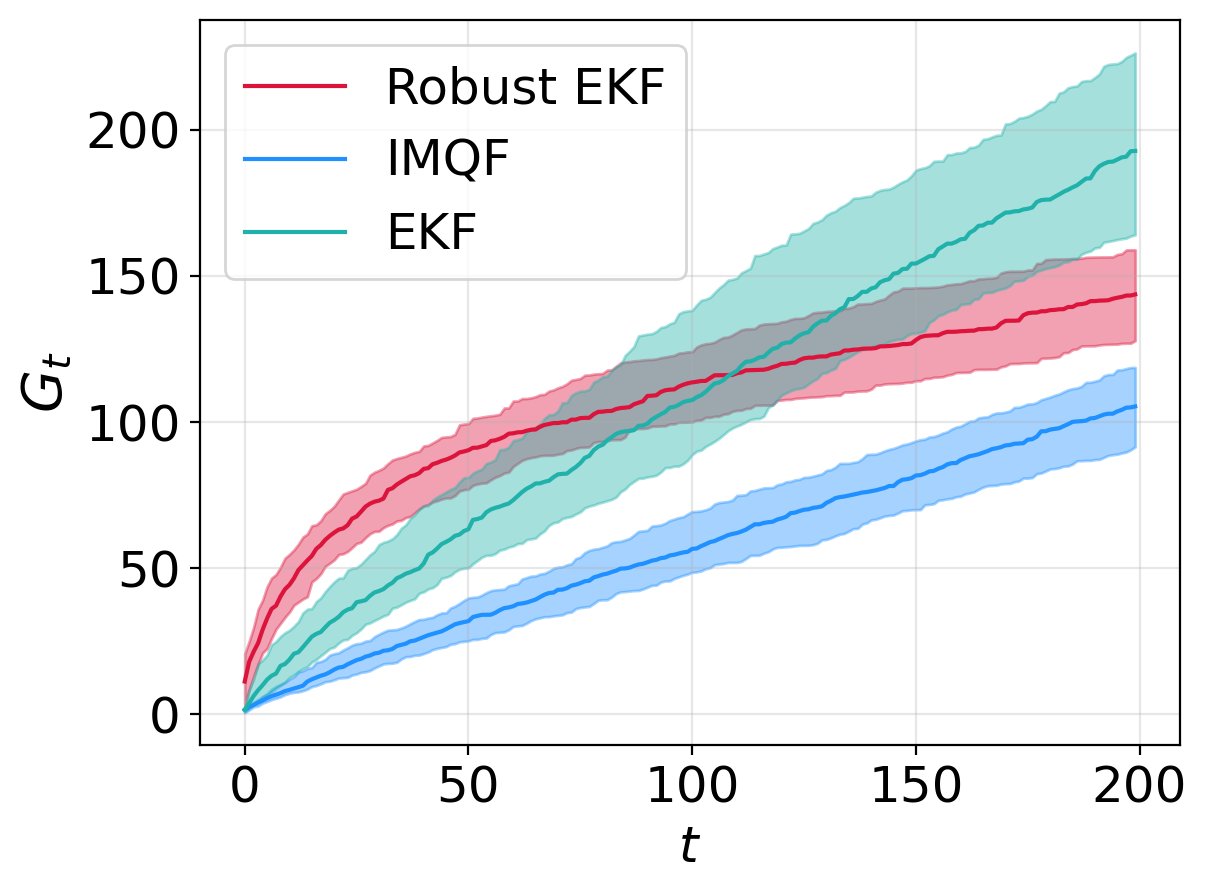

In [18]:
for method in cmap:
    plt.plot(np.nanquantile(errs_rmean[method], 0.5, axis=0), c=cmap[method], label=method)
    vmin, vmax = np.nanquantile(errs_rmean[method], [0.2, 0.8], axis=0)
    plt.fill_between(np.arange(len(vmin)), vmin, vmax, color=cmap[method], alpha=0.4)

# plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("$t$")
plt.ylabel("$G_t$", fontsize=20)
plt.tight_layout()
plt.savefig("./figures/online-mlp-osa-benchmark.pdf")

In [19]:
results_osa_df = jax.tree_map(lambda errs: jnp.sqrt(jnp.power(errs, 2)[:, 0:].sum(axis=1)), errs_osa)
results_osa_df = pd.DataFrame(results_osa_df)
results_osa_df.describe()

,EKF,IMQF,Robust EKF
count,100.000000,100.000000,100.000000
mean,208.272095,106.233154,273.776978
std,89.289566,17.369991,1300.577515
min,121.408142,75.393646,108.855026
25%,166.863544,94.878073,131.997723
50%,192.768494,105.366985,143.671623
75%,216.450722,116.318455,155.526630
max,740.101562,174.379791,13148.399414


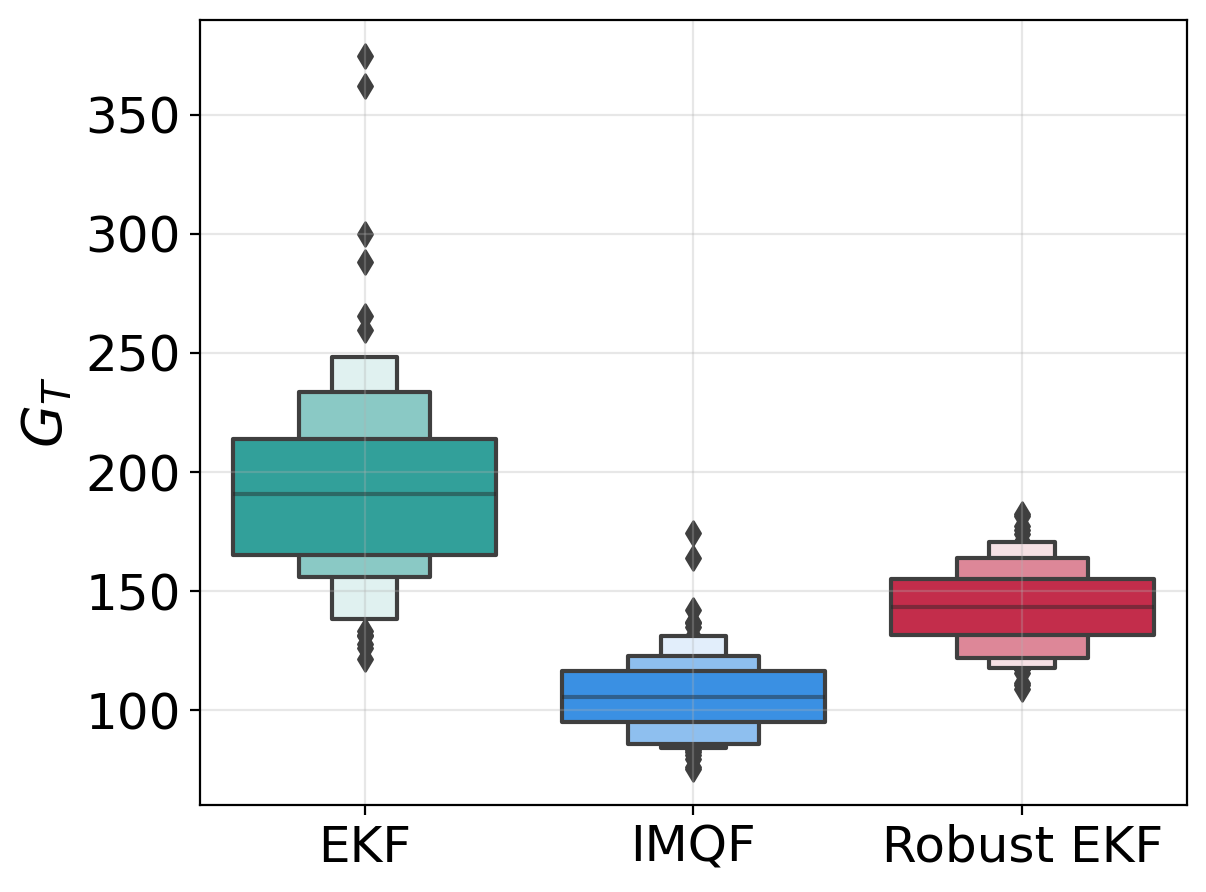

In [20]:
sns.boxenplot(
    results_osa_df.melt().query("value < 400"),
    x="variable", y="value",
    palette=cmap
)
plt.grid(alpha=0.3)
# plt.yscale("log")
plt.xlabel("")
plt.ylabel("$G_T$", fontsize=20)
plt.tight_layout()
plt.savefig("./figures/online-mlp-benchmark.pdf")

## Sampled results

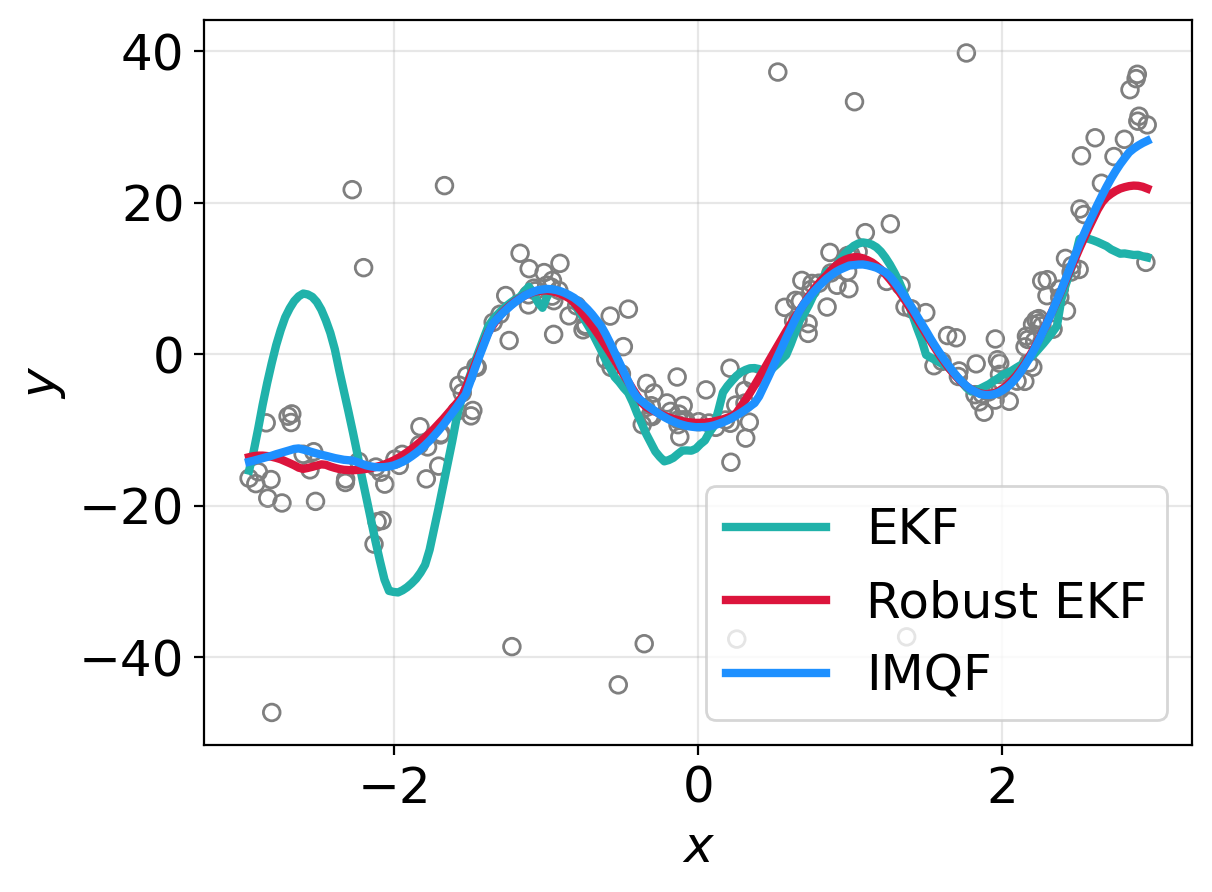

In [22]:
_, (agent_imq, bel_imq) = filter_imqf(3.0)
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

plt.scatter(x, y, edgecolors="tab:gray", c="none")
plt.plot(xtest, yhat_ekf, c="lightseagreen", linewidth=3, label="EKF")
plt.plot(xtest, yhat_rekf, c="crimson", linewidth=3, label="Robust EKF")
plt.plot(xtest, yhat_imq, c="dodgerblue", linewidth=3, label="IMQF")
plt.grid(alpha=0.3)
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig("./figures/online-mlp-sample.pdf")